In [19]:
import ccxt
import pandas_ta as ta
import pandas as pd
import warnings

In [20]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [21]:
def fetchOhlcv(code, start, end):
    
	exchange = ccxt.binance()

	start = exchange.parse8601(f'{start}T00:00:00Z')
	end   = exchange.parse8601(f'{end}T23:59:59Z')

	ohlcv = []

	while start < end:

		rst = exchange.fetch_ohlcv(code, '1h', start)
		if start == rst[-1][0]:
			break

		ohlcv.extend(rst)
		start = rst[-1][0]
		
	df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
	return df[df['timestamp'].between(0, end)]

In [22]:
def clustering(arr, distance):

	if len(arr) == 0:
		return []

	clusters = []
	current_cluster = [arr[0]]

	for i in range(1, len(arr)):
		if arr[i] - arr[i - 1] <= distance:
			current_cluster.append(arr[i])
		else:
			clusters.append(current_cluster)
			current_cluster = [arr[i]]

	clusters.append(current_cluster)

	return clusters


def sortWith(clusters, data, k):
	return [
		sorted(cluster, key=lambda x: data[x])[k if k < len(cluster) else 0]
		for cluster in clusters
	]

In [23]:
def _createFeature(o, h, l, c, v, i):
	rsi = ta.rsi(c, 14)
	ema = ta.ema(c, 20)
	sma = ta.sma(c, 20)
	cci = ta.cci(h,l,c, 20)
	h_rsi = ta.rsi(h, 14)
	h_ema = ta.ema(h, 20)
	h_sma = ta.sma(h, 20)
	l_rsi = ta.rsi(l, 14)
	l_ema = ta.ema(l, 20)
	l_sma = ta.sma(l, 20)
	v_rsi = ta.rsi(v, 14)
	v_ema = ta.ema(v, 20)
	v_sma = ta.sma(v, 20)

	return [
		rsi.iloc[i] / 100,
		ema.iloc[i] / c.iloc[i] - 1,
		sma.iloc[i] / c.iloc[i] - 1,
		cci.iloc[i] / 100,
		h_rsi.iloc[i] / 100,
		h_ema.iloc[i] / h.iloc[i] - 1,
		h_sma.iloc[i] / h.iloc[i] - 1,
		l_rsi.iloc[i] / 100,
		l_ema.iloc[i] / l.iloc[i] - 1,
		l_sma.iloc[i] / l.iloc[i] - 1,
		v_rsi.iloc[i] / 100,
		v_ema.iloc[i] / v.iloc[i] - 1,
		v_sma.iloc[i] / v.iloc[i] - 1,
	]



def createFeatures(df, idx, heikin=[]):

	if not len(heikin):
		heikin = ta.ha(df['open'], df['high'], df['low'], df['close'])

	f = _createFeature(
		heikin['HA_open'].squeeze(),
		heikin['HA_high'].squeeze(),
		heikin['HA_low'].squeeze(),
		heikin['HA_close'].squeeze(),
		df['volume'].squeeze(),
		idx
	)
	
	f2 = _createFeature(
		df['open'].squeeze(),
		df['high'].squeeze(),
		df['low'].squeeze(),
		df['close'].squeeze(),
		df['volume'].squeeze(),
		idx
	)

	return f + f2

In [24]:

def createDataset(df):
    
	# find points
	long = []
	short = []
	hold = []


	heikin = ta.ha(df['open'], df['high'], df['low'], df['close'])
	rsi = ta.rsi(df['close'], 14)

	us = heikin['HA_open'] == heikin['HA_low']
	s = heikin['HA_open'] < heikin['HA_close']

	for i, v in enumerate(df['close']):


		if us.iloc[i] \
		and rsi.iloc[i] < 70 \
		and (df['close'].iloc[i:i+50].mean() - v) / v >= 0.04:
			long.append(i)

		elif s.iloc[i-1] and not s.iloc[i] \
		and rsi.iloc[i] > 30 \
		and (df['close'].iloc[i:i+50].mean() - v) / v <= -0.04:
			short.append(i)
			
		elif rsi.iloc[i] < 70 and rsi.iloc[i] > 30 \
		and (df['close'].iloc[i:i+150].mean() - v) / v >= -0.01 and (df['close'].iloc[i:i+150].mean() - v) <= 0.01:
			hold.append(i)
			


	long  = sortWith(clustering(long, 20), df['close'], 0)
	short = sortWith(clustering(short, 20), df['close'], -1)
	hold  = [hs[round(len(hs)/2)] for hs in clustering(hold, 20)]


	# create Dataset format
	x = []
	y = []

	for idx in long + short + hold:

		x.append(createFeatures(df, idx, heikin=heikin))

		if idx in long:
			y.append(0)
		elif idx in short:
			y.append(1)
		elif idx in hold:
			y.append(2)

	return x, y

In [25]:
def createDatasets(symbols, start, end):

	x = []
	y = []
    
	for symbol in symbols:
		print(f'{symbol} is preprocessing... ', end='\r')
		
		_x, _y = createDataset(fetchOhlcv(symbol, start, end))
		x += _x
		y += _y
		
	
	print(f'0 label : {y.count(0)}                          ')
	print(f'1 label : {y.count(1)}                          ')
	print(f'2 label : {y.count(2)}                          ')

	return x, y

In [26]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint, uniform
import xgboost as xgb
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
if __name__ == '__main__':

	x, y = createDatasets(['BTC/USDT', 'ETH/USDT', 'SOL/USDT', 'XRP/USDT', 'ADA/USDT', 'TRX/USDT'], '2021-01-01', '2024-07-01')

	# Delete nan and inf 
	df = pd.DataFrame({'x' : x, 'y' : y})
	df = df[df['x'].apply(lambda x: not np.isnan(x).all() and not np.isinf(x).any())]



	rus = RandomUnderSampler(random_state=42, sampling_strategy={2 : round((y.count(0) + y.count(1))/2)})
	x_resampled, y_resampled = rus.fit_resample(df['x'].squeeze().tolist(), df['y'].squeeze().tolist())

	x_train, x_test, y_train, y_test = train_test_split(
		x_resampled, y_resampled, test_size=0.2, random_state=42
	)

In [ ]:
if __name__ == '__main__':

	param_grid = {
		"n_estimators": randint(100, 1000),
		"learning_rate": uniform(0.01, 0.3),
		"max_depth": randint(3, 10),
		"min_child_weight": randint(1, 10),
		"subsample": uniform(0.65, 0.4),
		"colsample_bytree": uniform(0.65, 0.4),
		"gamma": uniform(0, 0.5),
		"alpha": uniform(0, 1),
		"lambda": uniform(0, 1),
		"colsample_bylevel": uniform(0.6, 0.4),
		"colsample_bynode": uniform(0.6, 0.4),
	}

	random_search = RandomizedSearchCV(
		estimator=xgb.XGBClassifier(
			objective="multi:softmax", num_class=3, random_state=42
		),
		param_distributions=param_grid,
		n_iter=1000,
		scoring="accuracy",
		cv=2,
		verbose=2,
		random_state=42,
		n_jobs=-1,
	)

	random_search.fit(x_train, y_train)
	model = random_search.best_estimator_

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits
[CV] END alpha=0.12203823484477883, colsample_bylevel=0.798070764044508, colsample_bynode=0.6137554084460873, colsample_bytree=1.013728160831513, gamma=0.12938999080000846, lambda=0.662522284353982, learning_rate=0.10351332282682328, max_depth=8, min_child_weight=6, n_estimators=205, subsample=0.8770801311279967; total time=   0.0s
[CV] END alpha=0.12203823484477883, colsample_bylevel=0.798070764044508, colsample_bynode=0.6137554084460873, colsample_bytree=1.013728160831513, gamma=0.12938999080000846, lambda=0.662522284353982, learning_rate=0.10351332282682328, max_depth=8, min_child_weight=6, n_estimators=205, subsample=0.8770801311279967; total time=   0.0s
[CV] END alpha=0.6803075385877797, colsample_bylevel=0.7801997007878172, colsample_bynode=0.6053059844639466, colsample_bytree=1.026880702273941, gamma=0.28164410892276964, lambda=0.3854165025399161, learning_rate=0.014789875666064259, max_depth=4, min_child_weight=4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.69053118 0.68533487 0.6778291         nan        nan 0.68360277
        nan        nan 0.67840647        nan 0.6778291  0.68822171
 0.68533487 0.68879908 0.6778291  0.68475751 0.67263279 0.67321016
        nan 0.68071594        nan        nan        nan 0.69110855
        nan        nan 0.67898383 0.6830254  0.6812933  0.6812933
 0.68071594 0.68244804 0.67494226 0.68475751 0.6812933  0.68360277
        nan 0.676097          nan 0.67551963        nan 0.68475751
        nan 0.68591224 0.67840647 0.68822171 0.6795612         nan
        nan        nan 0.6795612         nan        nan 0.67263279
 0.67378753 0.68418014 0.68244804 0.6778291  0.6830254  0.6778291
 0.68764434 0.68244804        nan 0.68244804 0.6812933  0.67840647
 0.68360277        nan        nan 0.67551963 0.68418014 0.69284065
        nan 0.681

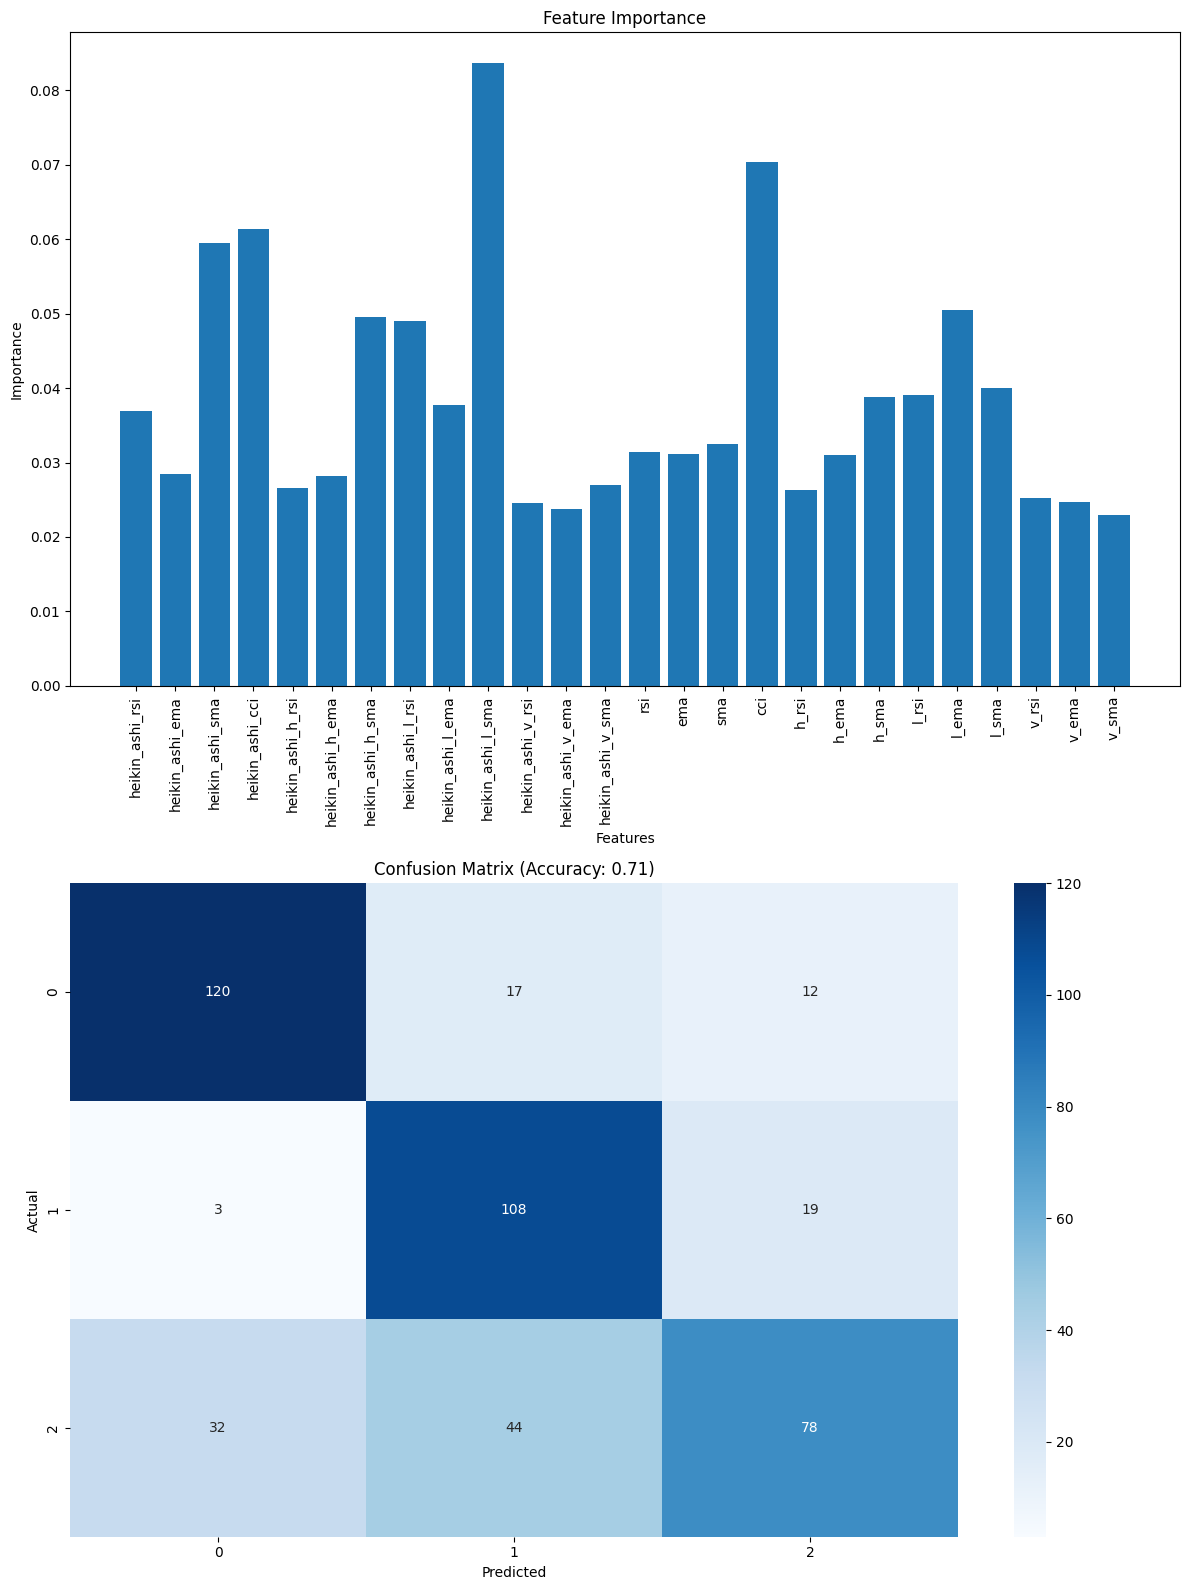

In [ ]:
if __name__ == '__main__':

	feature_names = [
		'heikin_ashi_rsi', 'heikin_ashi_ema', 'heikin_ashi_sma', 'heikin_ashi_cci',
		'heikin_ashi_h_rsi', 'heikin_ashi_h_ema', 'heikin_ashi_h_sma',
		'heikin_ashi_l_rsi', 'heikin_ashi_l_ema', 'heikin_ashi_l_sma',
		'heikin_ashi_v_rsi', 'heikin_ashi_v_ema', 'heikin_ashi_v_sma',
		'rsi', 'ema', 'sma', 'cci',
		'h_rsi', 'h_ema', 'h_sma',
		'l_rsi', 'l_ema', 'l_sma',
		'v_rsi', 'v_ema', 'v_sma',
	]


	y_pred = model.predict(x_test)
	accuracy = accuracy_score(y_test, y_pred)
	cm = confusion_matrix(y_test, y_pred)

	fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

	ax1.bar(feature_names, model.feature_importances_)
	ax1.set_title("Feature Importance")
	ax1.set_xlabel("Features")
	ax1.set_ylabel("Importance")
	ax1.tick_params(axis='x', rotation=90)

	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax2)
	ax2.set_title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")
	ax2.set_ylabel("Actual")
	ax2.set_xlabel("Predicted")

	plt.tight_layout()
	plt.show()


In [16]:

def isDowntrend(df, i, trend_period=100):
		if i < trend_period:
			return False
		
		prices = df['close'].iloc[i-trend_period:i].values
		x = np.arange(trend_period)
		slope, _ = np.polyfit(x, prices, 1)
		
		return slope < 0  # True if downtrend, False if uptrend


def finder(df, model, threshold = 0.9):

	heikin = ta.ha(df['open'], df['high'], df['low'], df['close'])
	x_backtest = []

	for i in range(len(df)):
		x_backtest.append(createFeatures(df, i, heikin=heikin))
		

	proba = model.predict_proba(x_backtest)
	proba = pd.DataFrame(proba)

	p0 = proba[0][proba[0] > threshold].index

	us = heikin['HA_open'] == heikin['HA_low']
	s = heikin['HA_open'] < heikin['HA_close']

	p0 = [p for p in p0 if isDowntrend(df, p)]

	return p0, proba


In [ ]:

if __name__ == '__main__':

	symbol = 'BTC/USDT'
	start = '2025-01-01'
	end = '2025-03-22'
	threshold = 0.9


	df = fetchOhlcv(symbol, start, end)

	p0, proba = finder(df, model, threshold)



	fig = make_subplots(specs=[[{"secondary_y": True}]])

	fig.add_trace(go.Candlestick(
		open=df['open'].squeeze(),
		high=df['high'].squeeze(),
		low=df['low'].squeeze(),
		close=df['close'].squeeze(),
		x=df.index,
		name='candle'
	))
	fig.add_trace(go.Bar(
		x=df.loc[p0].index,
		y=proba[0].loc[p0],
		name='long',
		width=2
	), secondary_y=True)


	fig.update_layout(
		title=f'(Threshold: {threshold})',
		height=600
	)
	fig.update_yaxes(
		title='Probability',
		range=[0.4, 1],
		secondary_y=True
	)

	fig.show()


In [ ]:
# if __name__ == '__main__':
	# model.save_model('../models/v1.m')